In [1]:
import pandas as pd
import numpy as np
import os
os.listdir('../input')

['df_ref2_session.csv',
 'new_submission_dwell_time.csv',
 'new_submission_baseline.csv',
 'df_ref.csv',
 'ref_count2_baselineOnly_pred.csv',
 'train.csv',
 'df_ref2.csv',
 'submission_popular.csv',
 'item_metadata.csv',
 'df_full_except_noinfo.csv',
 'test.csv',
 'new_submission.csv',
 'dwell_df.csv',
 'baseline_sorting.csv',
 'dwell_time_agg.csv',
 'test2.csv']

In [2]:
path = '../input/'

In [146]:
df_ref = pd.read_csv(path + 'df_ref2_session.csv')
df_ref.reference = df_ref.reference.apply(str)
df_ref.ref_count = df_ref.ref_count.apply(int)
df_ref.head(3)

,user_id,session_id,reference,ref_count
0,0001VQMGUI65,466687f1875ee,3133074,11
1,0001VQMGUI65,466687f1875ee,2019467,1
2,0001VQMGUI65,466687f1875ee,4521140,1


In [89]:
filter_items = df_ref['reference'].value_counts() > 1
filter_items = filter_items[filter_items].index.tolist()

filter_users = df_ref['user_id'].value_counts() > 1
filter_users = filter_users[filter_users].index.tolist()

df_new = df_ref[(df_ref['reference'].isin(filter_items)) & (df_ref['user_id'].isin(filter_users))]

print('The original data frame shape : ', df_ref.shape)
print('The new data frame shape : ', df_new.shape)

del df_ref

The original data frame shape :  (2322841, 4)
The new data frame shape :  (1933316, 4)


In [99]:
baseline_sub = pd.read_csv(path + 'new_submission.csv')
baseline_sub.impressions = baseline_sub.impressions.apply(lambda x : x.split('|'))
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ..."
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ..."


In [91]:
aa = df_new.groupby('session_id')['reference'].apply(lambda x :' '.join(x)).to_frame().reset_index()
aa.reference = aa.reference.apply(lambda x : x.split(' '))
aa.rename(columns = {'reference' : 'ref_list'}, inplace = True)
aa.head(3)

,session_id,ref_list
0,000056cd97ce2,"[3811810, 2784325]"
1,0000be39860d7,"[79237, 445081, 4920008]"
2,0000c0fb51e11,"[673981, 10369176]"


In [92]:
print('baseline_sub shape : ', baseline_subline_sub.shape)
print('aa shape : ', aa.shape)

baseline_sub shape :  (121526, 6)
aa shape :  (607606, 2)


In [105]:
baseline_sub.reference = baseline_sub.reference.apply(str)
mrr(baseline_sub['reference'], baseline_sub['impressions'])

0.4517556722779725


In [106]:
baseline_sub = pd.merge(baseline_sub, aa)
print('shape : ', baseline_sub.shape)
baseline_sub.head(3)

shape :  (83799, 7)


,user_id,session_id,timestamp,step,reference,impressions,ref_list
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10...","[1050068, 2059240, 3241426]"
1,02AOAVF9PVYH,4a01c3afbc224,1541681239,45,1177554,"[1451247, 559056, 1045096, 1963879, 693596, 19...","[749491, 552311, 7304020, 1177554, 1177542, 66..."
2,0339C84S24ET,3e7d55eae386f,1541622146,3,8511456,"[10598152, 7031496, 7348404, 5753730, 7238840,...","[4957186, 8511456]"


In [107]:
def find_imp(imp, ref_list) :
    for ref in ref_list :
        if ref not in imp :
            ref_list.remove(ref)
            
    return ref_list

In [108]:
idx = baseline_sub[~baseline_sub.ref_list.isnull()].index
baseline_sub.loc[idx,'ref_list'] = baseline_sub.loc[idx].apply(lambda x : find_imp(x['impressions'], x['ref_list']), axis = 1)

In [109]:
s = baseline_sub.loc[idx].apply(lambda x: pd.Series(x['ref_list']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
print(len(s))

220798


In [113]:
testset = baseline_sub.loc[idx,['user_id', 'session_id']].join(s).reset_index(drop = True)
testset.rename(columns = {'item_id' : 'reference'}, inplace = True)
testset = pd.merge(testset, df_new)
testset.head(3)

,user_id,session_id,reference,ref_count
0,004A07DM0IDW,1d688ec168932,1050068,3
1,004A07DM0IDW,1d688ec168932,2059240,2
2,004A07DM0IDW,1d688ec168932,3241426,1


In [114]:
testset.shape

(220798, 4)

In [116]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import NormalPredictor
#from surprise import KNNBasic,KNNWithMeans,KNNWithZScore,KNNBaseline #memory error
from surprise import SVD, SVDpp, NMF
from surprise import BaselineOnly, CoClustering
from surprise import NormalPredictor
from surprise.accuracy import rmse
from surprise import accuracy

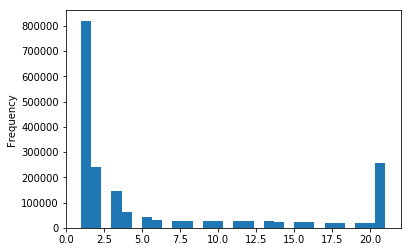

In [43]:
df_new.ref_count.plot.hist(bins = 30)

In [129]:
df_new.ref_count.describe()

count    1.933316e+06
mean     6.265562e+00
std      7.363268e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      1.000000e+01
max      2.100000e+01
Name: ref_count, dtype: float64

In [167]:
df_new.reference = df_new.reference.apply(int)
reader = Reader(rating_scale=(1,21))
data = Dataset.load_from_df(df_new[['session_id','reference','ref_count']], reader)
#by session_id

In [62]:
benchmark = []

# CV
## SVD

In [63]:
print('algorithm : ', 'SVD')
results = cross_validate(SVD(), data, measures=['RMSE'], cv = 3, verbose = False, n_jobs = -1)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('SVD', index = ['Algorithm']))
benchmark.append(tmp)
tmp #6.58461

algorithm :  SVD


fit_time     48.2006
test_rmse    6.58461
test_time    4.10611
Algorithm        SVD
dtype: object

## SVDpp

In [64]:
print('algorithm : ', 'SVDpp')
results = cross_validate(SVDpp(), data, measures=['RMSE'], cv = 3, verbose = False, n_jobs = -1)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('SVDpp', index = ['Algorithm']))
benchmark.append(tmp)
tmp #6.7882

algorithm :  SVDpp


fit_time     132.943
test_rmse     6.7882
test_time    8.62438
Algorithm      SVDpp
dtype: object

## baseline Only

In [66]:
print('algorithm : ', 'BaselineOnly')
results = cross_validate(BaselineOnly(), data, measures=['RMSE'], cv = 3, verbose = False, n_jobs = -1)

#get results
tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
tmp = tmp.append(pd.Series('BaselineOnly', index = ['Algorithm']))
benchmark.append(tmp)
tmp #6.66078

algorithm :  BaselineOnly


fit_time          1.54545
test_rmse         6.66078
test_time          3.3099
Algorithm    BaselineOnly
dtype: object

# train test split

In [67]:
trainset,testset = train_test_split(data, test_size = 0.3)

## SVD

In [68]:
algo = SVD(lr_all = 0.01, n_epochs = 30)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred) #RMSE: 6.5272

RMSE: 6.5272


6.527242576422158

## SVDpp

In [69]:
algo = SVDpp(lr_all = 0.01, n_epochs = 30)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred) #RMSE: 6.7223

RMSE: 6.7223


6.722319277006939

## BaselineOnly

In [70]:
bsl_options = {'method' : 'als',
              'n_epochs' : 10,
              'reg_u' : 5,
              'reg_i' : 5}

algo = BaselineOnly(bsl_options=bsl_options)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred) #RMSE: 6.3431 best

Estimating biases using als...
RMSE: 6.3431


6.343134657435686

# predict

In [155]:
baseline_sub = pd.read_csv(path + 'new_submission.csv')
baseline_sub.impressions = baseline_sub.impressions.apply(lambda x : x.split('|'))
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ..."
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ..."


In [136]:
print(testset.shape)
testset.head(3)

(220798, 4)


,user_id,session_id,reference,ref_count
0,004A07DM0IDW,1d688ec168932,1050068,3
1,004A07DM0IDW,1d688ec168932,2059240,2
2,004A07DM0IDW,1d688ec168932,3241426,1


## Baselineonly

In [156]:
bsl_options = {'method' : 'als',
              'n_epochs' : 10,
              'reg_u' : 5,
              'reg_i' : 5}

algo = BaselineOnly(bsl_options=bsl_options)

trainset = data.build_full_trainset()
fitting = algo.fit(trainset)

Estimating biases using als...


In [194]:
item_unique = testset.reference.unique()
item_unique = item_unique.astype(np.int)

In [158]:
print('session id : ',len(testset.session_id.unique()))
print('item id : ',len(item_unique))

session id :  83331
item id :  93153


In [207]:
pred = []
pred_df = pd.DataFrame(columns = ['uid','iid','est'])

i = 0
for sess in testset.session_id.unique() :
    i+=1
    if i%1000 == 0 :
        print('{}번째 id'.format(i))
        if len(pred) > 0 :
            pred = pd.DataFrame(pred)[['uid','iid','est']]
            pred_df = pred_df.append(pred)
            pred_df.to_csv(path + 'ref_count2_baselineOnly_pred.csv', index = False)
            pred = []
    
    iid = baseline_sub[baseline_sub.session_id == sess]['impressions'].values[0]
    iid = list(map(int, iid))

    for item in iid :
        if item in item_unique :
            algo_pred = algo.predict(sess, item)
            pred.append(algo_pred)

1000번째 id
2000번째 id
3000번째 id
4000번째 id
5000번째 id
6000번째 id
7000번째 id
8000번째 id
9000번째 id
10000번째 id
11000번째 id
12000번째 id
13000번째 id
14000번째 id
15000번째 id
16000번째 id
17000번째 id
18000번째 id
19000번째 id
20000번째 id
21000번째 id
22000번째 id
23000번째 id
24000번째 id
25000번째 id
26000번째 id
27000번째 id
28000번째 id
29000번째 id
30000번째 id
31000번째 id
32000번째 id
33000번째 id
34000번째 id
35000번째 id
36000번째 id
37000번째 id
38000번째 id
39000번째 id
40000번째 id
41000번째 id
42000번째 id
43000번째 id
44000번째 id
45000번째 id
46000번째 id
47000번째 id
48000번째 id
49000번째 id
50000번째 id
51000번째 id
52000번째 id
53000번째 id
54000번째 id
55000번째 id
56000번째 id
57000번째 id
58000번째 id
59000번째 id
60000번째 id
61000번째 id
62000번째 id
63000번째 id
64000번째 id
65000번째 id
66000번째 id
67000번째 id
68000번째 id
69000번째 id
70000번째 id
71000번째 id
72000번째 id
73000번째 id
74000번째 id
75000번째 id
76000번째 id
77000번째 id
78000번째 id
79000번째 id
80000번째 id
81000번째 id
82000번째 id
83000번째 id


In [209]:
pred_df.rename(columns = {'uid' : 'session_id'}, inplace = True)
pred_df.head(3)

,session_id,iid,est
0,1d688ec168932,2059240,3.714849
1,1d688ec168932,2033381,6.146838
2,1d688ec168932,1724779,7.527305


In [210]:
#pred_df.to_csv(path + 'ref_count2_baselineOnly_pred.csv', index = False)

# scoring

In [211]:
pred_df = pred_df.groupby('session_id').apply(lambda x : x.sort_values(['est'], ascending = False)).reset_index(drop = True)
pred_df.iid = pred_df.iid.apply(str)
pred_df.head(3)

,session_id,iid,est
0,0000e0500c2e7,3793522,6.993011
1,0000e0500c2e7,8342182,5.663945
2,0000e0500c2e7,9377514,5.573696


In [212]:
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ..."
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ..."


In [213]:
pred_df = pred_df.groupby('session_id')['iid'].apply(lambda x : ' '.join(x)).to_frame().reset_index()
pred_df.iid = pred_df.iid.apply(lambda x : x.split(' '))
pred_df.head(3)

,session_id,iid
0,0000e0500c2e7,"[3793522, 8342182, 9377514, 2605288, 7354306, ..."
1,000177b850519,"[17529, 16831, 2759696, 153594, 9117602, 17579..."
2,00017b3b2c136,"[2810449, 1101646, 509856, 5717238, 2565452, 4..."


In [214]:
baseline_sub = pd.merge(baseline_sub, pred_df)
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions,iid
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10...","[1963235, 4491766, 5162722, 3442272, 1724779, ..."
1,02AOAVF9PVYH,4a01c3afbc224,1541681239,45,1177554,"[1451247, 559056, 1045096, 1963879, 693596, 19...","[2617856, 1967173, 1045096, 1052844, 1052880, ..."
2,0339C84S24ET,3e7d55eae386f,1541622146,3,8511456,"[10598152, 7031496, 7348404, 5753730, 7238840,...","[7031496, 10598152, 8511456, 9820556, 5753730]"


In [215]:
def sort_again(imp, ref) :
    my = []
    for rr in ref :
        if rr in imp :
            my.append(rr)
            imp.remove(rr)
    imp = my + imp
    return imp

In [216]:
baseline_sub['impressions'] = baseline_sub.apply(lambda x : sort_again(x['impressions'], x['iid']), axis = 1)
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions,iid
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[1963235, 4491766, 5162722, 3442272, 1724779, ...","[1963235, 4491766, 5162722, 3442272, 1724779, ..."
1,02AOAVF9PVYH,4a01c3afbc224,1541681239,45,1177554,"[2617856, 1967173, 1045096, 1052844, 1052880, ...","[2617856, 1967173, 1045096, 1052844, 1052880, ..."
2,0339C84S24ET,3e7d55eae386f,1541622146,3,8511456,"[7031496, 10598152, 8511456, 9820556, 5753730,...","[7031496, 10598152, 8511456, 9820556, 5753730]"


In [217]:
def mrr(answer, imp) :
    myscore = 0
    
    for i,j in zip(answer, imp) :
        if i in j :
            myscore += 1/(j.index(i) + 1)
    print(myscore / len(imp))

In [218]:
baseline_sub.reference = baseline_sub.reference.apply(str)
mrr(baseline_sub['reference'], baseline_sub['impressions'])

0.24948708816131487
